# Business Problem
O CEO da House Moon Company, deseja comprar casas com preço baixo e revende-lás com o preço mais alto. Encontre bons negócios dentro do portfólio disponível, ou seja, encontrar casas com preço baixo, que tenham um ótimo potencial de venda.

### Main Objective:

Uma vez o imóvel comprado, qual o melhor preço para vendê-lo?

* A House Moon deveria fazer uma reforma para aumentar o preço da venda? Quais seriam as sugestões de mudanças? Qual o incremento no preço dado por cada opção de reforma?

* 1- 30% a mais no preço caso o imóvel não foi renovado nenhuma vez.
* 2- 10% a mais no preço caso o imóvel ja foi renovado.

### Strategy:
1. Research on the scope of the problem
2. Data Collect
3. Data Cleaning (missing values, inconsistent values)
4. Descriptve Statistic
4. Create business hypotheses
5. Exploratory Data Analysis (attribute analysis, validate the hypotheses)
6. Data Preprocessing (data split, data scaling)
7. Feature Selection
7. Training the model (Random Forest, Lasso, ElasticNet)
8. Hyperparameter fine-tuning
9. Cross-validation
10. Translation of model performance to business performance
11. Deploy to Production: [House Price App](https://house-price-predict-sc30.herokuapp.com/)

# Business Results

O preço da venda dos imóveis foi calculado nas seguintes condições:

* 1- 30% a mais no preço caso o imóvel não foi renovado nenhuma vez.
* 2- 10% a mais no preço caso o imóvel ja foi renovado.

| Renovated Condition | Total Cost          | Sales Revenue        |Profit               |
| :---------------:   | :-------------:     | :-----------:        | :----:              |
| 1                   | US$\$$ 9.251.729.974|US$\$$ 12.027.248.966 |US$\$$ 2.775.518.992 |
| 2                   | US$\$$ 424.000.423  |US$\$$ 466.400.465    |US$\$$ 42.400.042    |
| **TOTAL**           | US$\$$ 9.675.730.397|US$\$$ 12.493.649.431 |US$\$$ 2.817.919.034 |

A House Moon reformando seus imóveis teria um lucro de: **US$ 2.817.919.034**

# 1.0 Imports

In [2]:
import pandas as pd
import numpy as np

from scipy.stats import skew, kurtosis

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score

import pickle

from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')

# 2.0 Functions

In [3]:
def remove_outliers(data, x):
    Q1 = np.percentile(data[x], 25)
    Q3 = np.percentile(data[x], 75)
    
    iqr = Q3 - Q1
    cut_off = iqr * 1.5
    lower, upper = 1, (Q3 + cut_off)
    
    data = data[(data[x] < upper) & (data[x] > lower)]
    print(f"Outliers of {x} are removed\n")
    
    return data

def plot_out(data, x):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    sns.set_style('darkgrid')
    
    sns.boxplot(x= data[x], ax= ax[0]);
    sns.histplot(data= data, x= x, bins=20, ax=ax[1]);

    plt.show()
    
    return None

def plot_rooms(data, x):
    fig, ax = plt.subplots(3, 1, figsize=(15, 10))
    sns.set_style('darkgrid')
    
    sns.countplot(data= data, x= x, ax=ax[0])
    sns.stripplot(x=x, y='price', data=data, ax=ax[1]);
    sns.histplot(data= data, x=x, ax=ax[2], bins=20);
    

    plt.subplots_adjust(hspace=0.3)
    plt.show()
    
    return None

def metrics(X_train, y_train, X_test, y_test, model):
    pred = model.predict(X_test)
    
    MAE = mean_absolute_error(y_test, pred)
    MSE = mean_squared_error(y_test, pred)
    RMSE = mean_squared_error(y_test, pred, squared=False)
    rs = r2_score(y_test, pred)
    
    print("MSE: {}\n".format(MSE))
    print("RMSE: {}\n".format(RMSE))
    print("R2: {}\n".format(rs))
    print("MAE: {}".format(MAE))

    '''
    X_test = pd.DataFrame(X_test)
    
    times = 5
    for i in range(times):
        rnd = np.random.randint(0, y_test.shape[0] - 1)
        real = y_test.iloc[rnd]
        pred = int(model.predict(X_test.iloc[rnd].to_frame().T)[0])
        print("Real Value      ----->>>>> {} $".format(real))
        print("Predicted Value ----->>>>> {} $\n".format(pred))
    '''
    
    return None

def random_search(model, param, x, y):
    kf = KFold(n_splits=3, random_state=0, shuffle=True)
    
    rs = RandomizedSearchCV(estimator = model,param_distributions = parameters,
                              scoring='neg_mean_absolute_error', 
                              cv = kf,
                              n_iter = 50)
    rs.fit(x, y)
    
    par   = rs.best_params_
    score = rs.best_score_
    estim = rs.best_estimator_
    
    print("The results obtained were:\n")
    print("Best MAE found: {}\n".format(round(abs(score)),2))
    print("Best parameters found: {}\n".format(par))
    print("Estimators found: {}".format(estim))
    
    return None

def get_percent(data):
    x = data.iloc[0,1]
    y = data.iloc[1,1]
    
    if (x > y):
        x1 = ((x - y) / y) * 100
        x1 = round(x1)
    else:
        x1 = ((y - x) / x) * 100
        x1 = round(x1)
        
    print('the PERCENT is: {}%'.format(x1))
    
    return None

def make_barplot(data, x, y):
    fig, ax = plt.subplots(figsize=(8,6))

    sns.barplot(data=data, x= x, y= y, ax=ax, palette='twilight')
    
    ax.set_facecolor('#EAEAF2')
    ax.set_xlabel(x, fontdict={'fontsize':14})
    ax.set_ylabel(y, fontdict={'fontsize':14})
    ax.tick_params(labelsize=14)
    fig.tight_layout()
    
    return None

# 3.0 Data Collect

In [4]:
data = pd.read_csv('kc_house_data.csv')
data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


# 4.0 Data Cleaning

* Verificando se tem valores ausentes, duplicados e os tipos das variáveis.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [6]:
data.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [7]:
data.duplicated().sum()

0

# 5.0 Descriptive Statistic 

Nessa etapa, foi feita uma estatística descritiva nos dados, para entender o comportamento dos dados.

* Skewness

Uma assimetria positiva, com valor > 0, significa que a cauda da distribuição está mais para a direita.

Uma assimetria negativa, com valor < 0, significa que a cauda da distribuição está mais para a esquerda.

* Kurtosis

Se igual 0, você tem uma distribuição **mesocúrtica**; 

Se maior que 0, **leptocúrtica**, correspondendo a uma curva mais pontuda; 

Se menor que 0, **platicúrtica**, ou seja, uma curva mais achatada, com maior variabilidade dos dados.

In [8]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

num_attributes = data.drop(['date','lat','long','zipcode','id'], axis=1)

min_ = pd.DataFrame(num_attributes.apply(np.min))
max_ = pd.DataFrame(num_attributes.apply(np.max))
mean = pd.DataFrame(num_attributes.apply(np.mean))
median = pd.DataFrame(num_attributes.apply(np.median))
std = pd.DataFrame(num_attributes.apply(np.std))
sk = pd.DataFrame(num_attributes.apply(skew))
kur = pd.DataFrame(num_attributes.apply(kurtosis))

sd = pd.concat([min_, max_, mean, median, std, sk, kur], axis=1).reset_index()
sd.columns = ['Attributes', 'Min', 'Max', 'Mean', 'Median', 'Std','Skewness', 'Kurtosis']
sd

,Attributes,Min,Max,Mean,Median,Std,Skewness,Kurtosis
0,price,75000.00,7700000.00,540088.14,450000.00,367118.70,4.02,34.58
1,bedrooms,0.00,33.00,3.37,3.00,0.93,1.97,49.05
2,bathrooms,0.00,8.00,2.11,2.25,0.77,0.51,1.28
3,sqft_living,290.00,13540.00,2079.90,1910.00,918.42,1.47,5.24
4,sqft_lot,520.00,1651359.00,15106.97,7618.00,41419.55,13.06,285.01
5,floors,1.00,3.50,1.49,1.50,0.54,0.62,-0.48
6,waterfront,0.00,1.00,0.01,0.00,0.09,11.38,127.60
7,view,0.00,4.00,0.23,0.00,0.77,3.40,10.89
8,condition,1.00,5.00,3.41,3.00,0.65,1.03,0.53
9,grade,1.00,13.00,7.66,7.00,1.18,0.77,1.19


# 6.0 Exploratory Data Analysis

## 6.1 Univariate Analysis

* Nessa etapa será feita uma análise de cada variável, checando se tem outliers e se precisar, removendo eles.

### 6.1.1 Price

* Nossa variável target.
* Coluna price tem bastante outliers.
* Foram removidos os outliers para não comprometer a máquina preditiva.

In [9]:
df = data.copy()

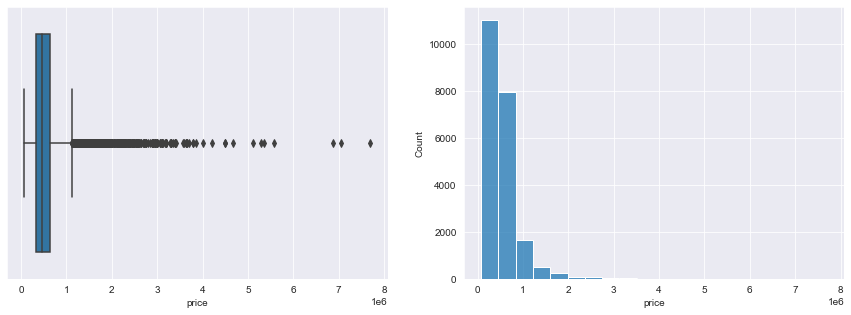

In [11]:
plot_out(df, 'price')

In [12]:
df = remove_outliers(df, 'price')

Outliers of price are removed



* Gráfico após a eliminação dos outliers.

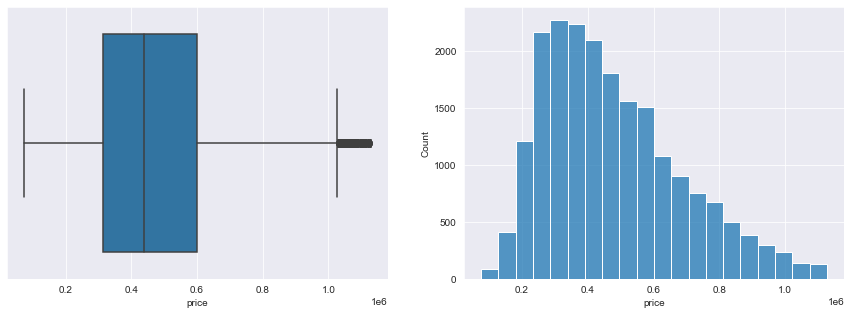

In [13]:
plot_out(df, 'price')

### 6.1.2 Bedrooms

* Nessa coluna **bedrooms** podemos observar que a partir de 7 ou 8 quartos são outliers.
* Será feita a remoção desses outliers.

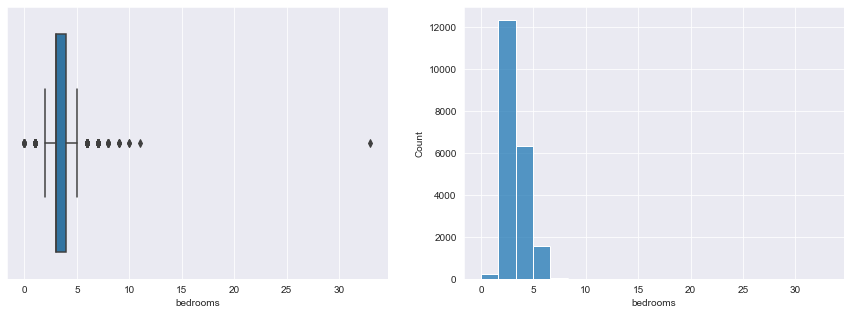

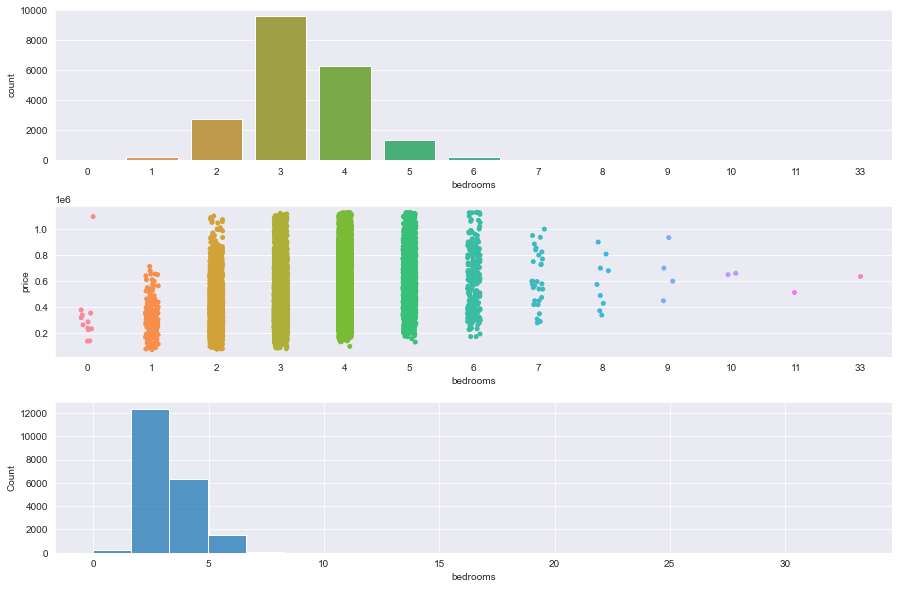

In [14]:
plot_out(df, 'bedrooms')
plot_rooms(df, 'bedrooms')

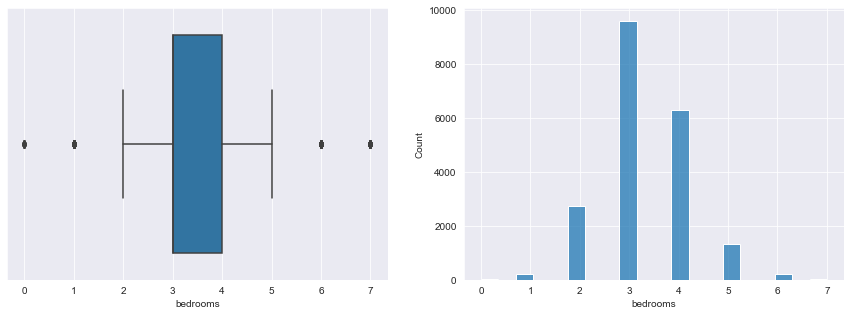

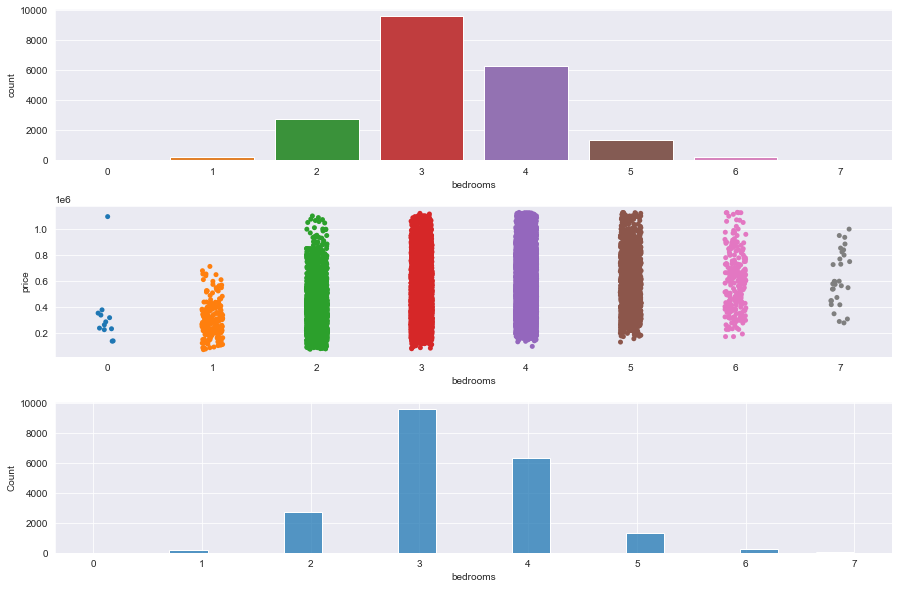

In [15]:
df = df[df.bedrooms < 8]

plot_out(df, 'bedrooms')
plot_rooms(df, 'bedrooms')

### 6.1.3 Bathrooms

* A coluna tem alguns outliers.
* Os valores 0.5, 0.75 e 1.25 se tornaram 1.0 por ter pouco valor.

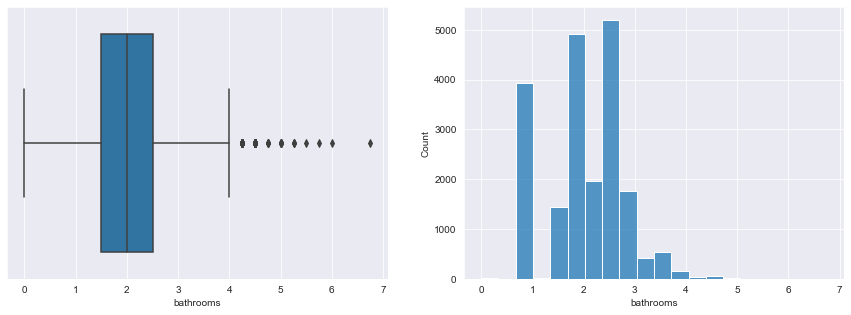

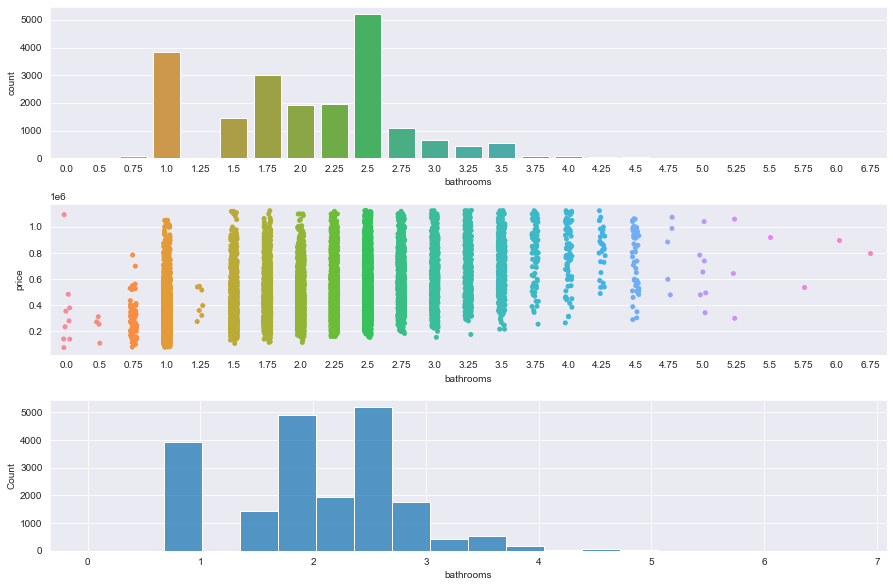

In [16]:
plot_out(df, 'bathrooms')
plot_rooms(df, 'bathrooms')

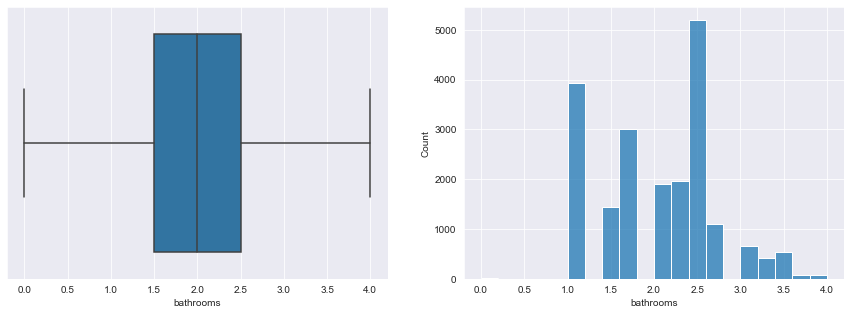

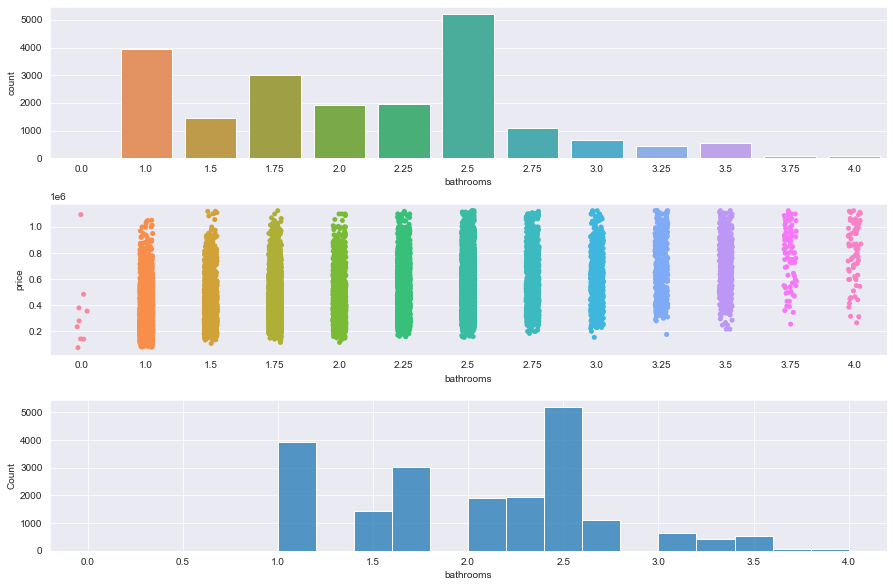

In [17]:
mask = (df.bathrooms < 4.25)
df = df[mask]
df['bathrooms'] = df['bathrooms'].apply(lambda x: 1 if (x == 0.5)
                                                   or (x == 0.75)
                                                   or (x == 1.25)
                                                   else x)

plot_out(df, 'bathrooms')
plot_rooms(df, 'bathrooms')

### 6.1.4 Floors

* Nessa coluna temos 1.5, 2.5 e 3.5 andar, considerando uma casa normal, esses valores serão corrigidos.

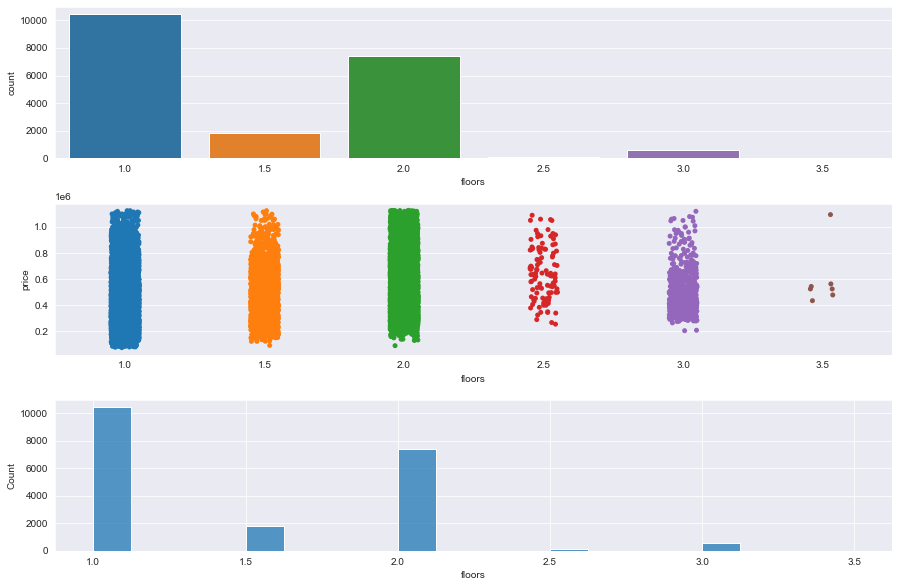

In [18]:
plot_rooms(df, 'floors')

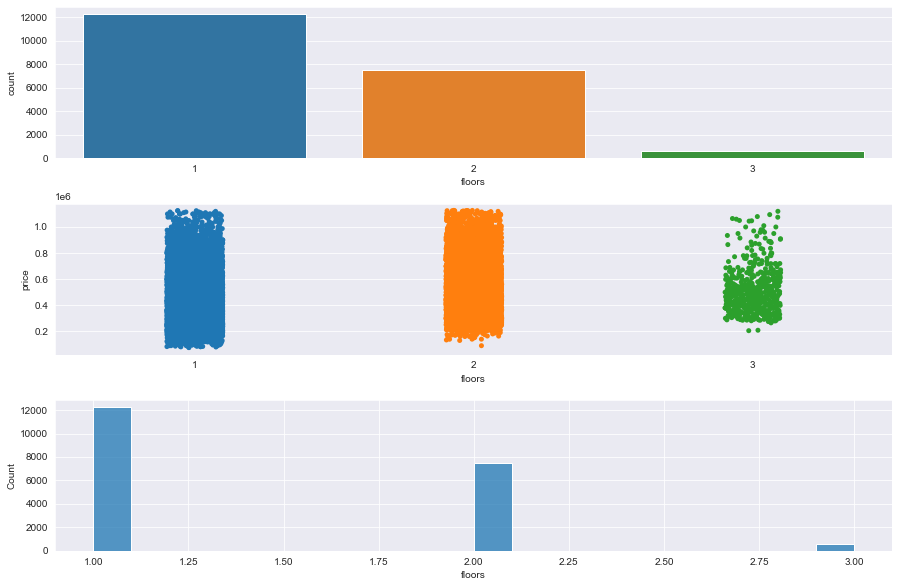

In [19]:
mask_floors = {1: 1, 1.5: 1, 2: 2, 2.5: 2, 3: 3, 3.5: 3}
df['floors'] = df['floors'].map(mask_floors)

plot_rooms(df, 'floors')

### 6.1.5 Waterview

* A coluna tem pouco registros com o valor 1.

In [20]:
df['waterfront'].value_counts()

0    20293
1       59
Name: waterfront, dtype: int64

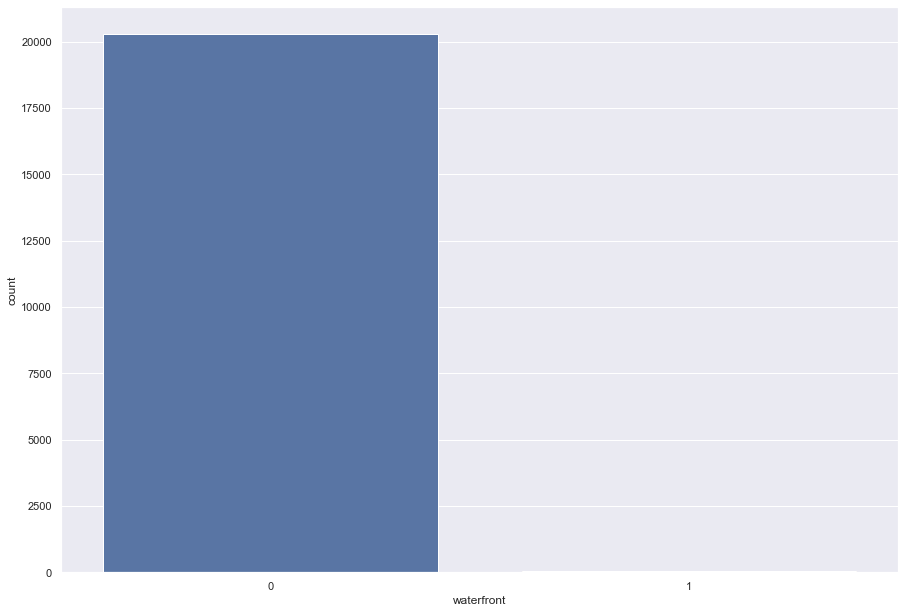

In [21]:
sns.set(rc={'figure.figsize':(15,10.4)})
sns.countplot(data= df, x='waterfront');

### 6.1.6 View

In [22]:
df['view'].value_counts()

0    18793
2      799
3      342
1      274
4      144
Name: view, dtype: int64

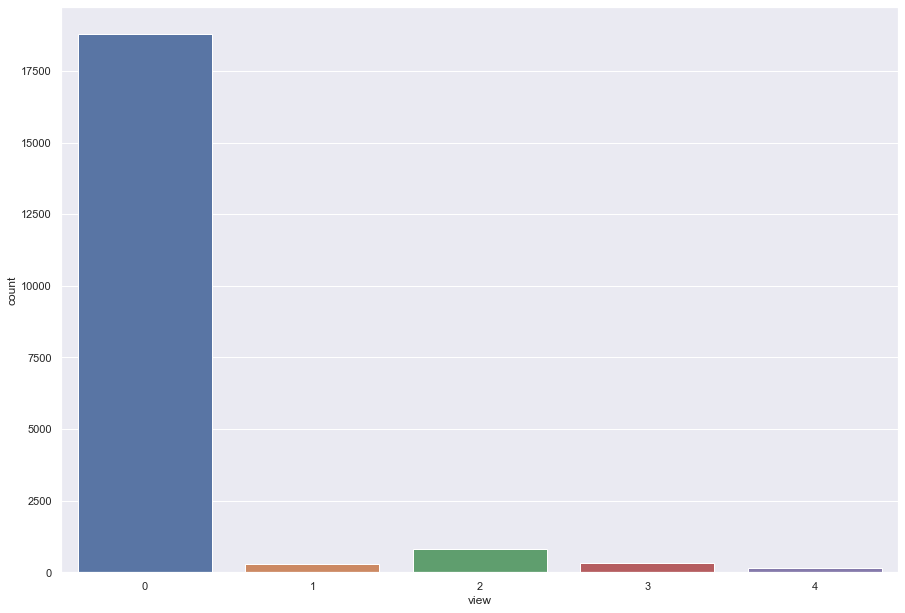

In [23]:
sns.countplot(data= df, x='view');

### 6.1.7 Condition

* Poucos valores na classe 1, após a etapa selection feature, se a coluna for relevante será feita uma limpeza.

In [24]:
df['condition'].value_counts()

3    13190
4     5407
5     1556
2      170
1       29
Name: condition, dtype: int64

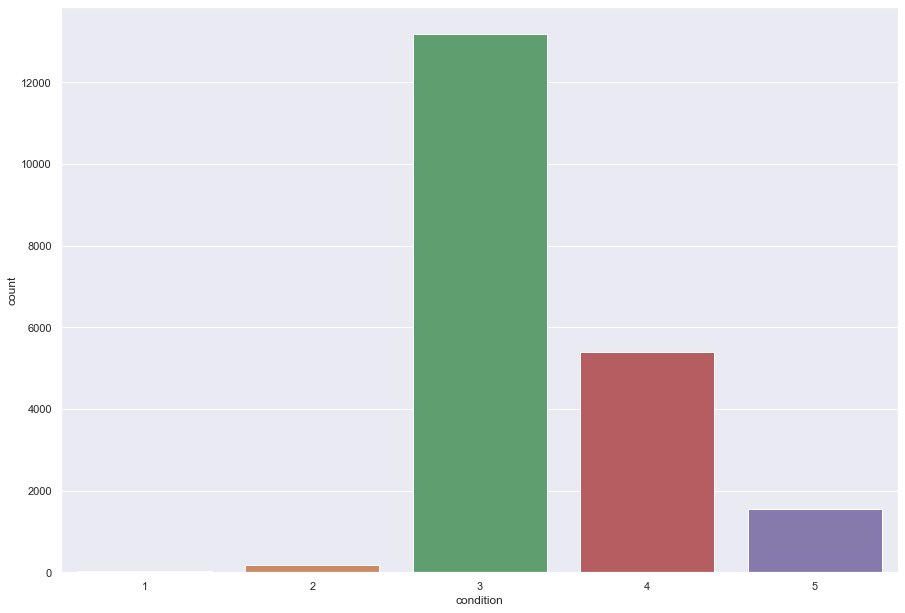

In [25]:
sns.countplot(data= df, x='condition');

### 6.1.8 Grade

* Mesma situação da coluna **condition**.

In [26]:
df['grade'].value_counts()

7     8939
8     5924
9     2309
6     2037
10     741
5      242
11     124
4       29
3        3
12       3
1        1
Name: grade, dtype: int64

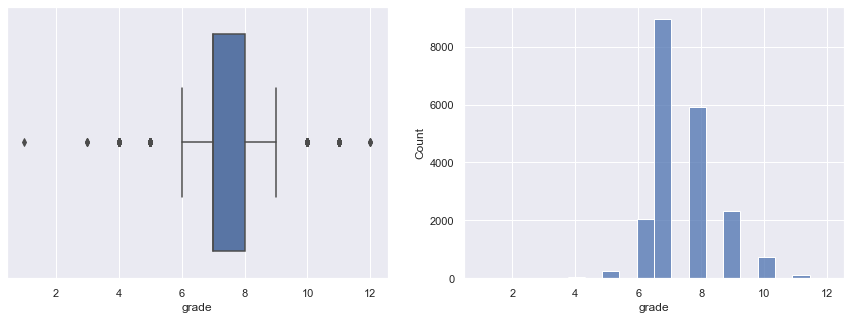

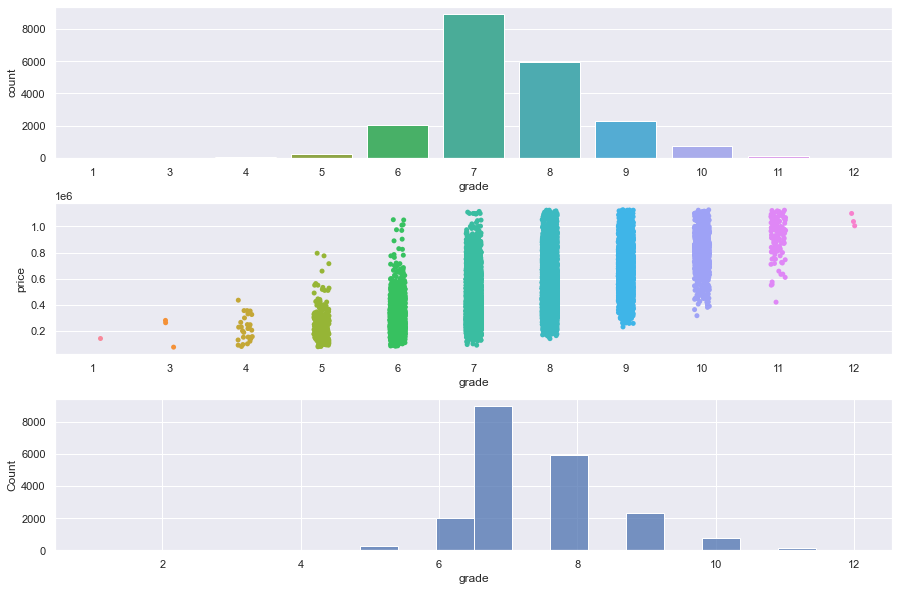

In [27]:
plot_out(df, 'grade')
plot_rooms(df, 'grade')

### 6.1.9 Year Built

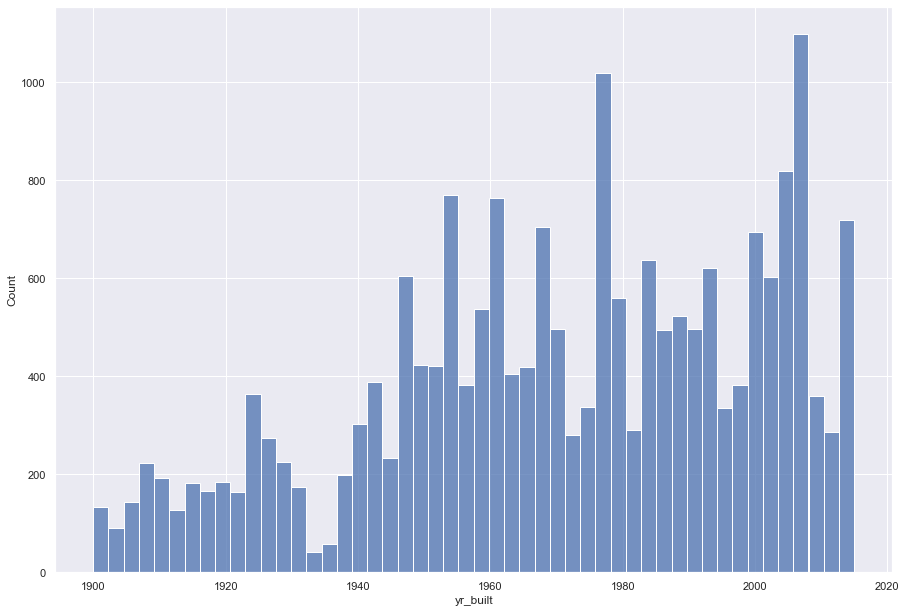

In [28]:
sns.histplot(data= df, x= 'yr_built', bins=50);

### 6.1.10 Year Renovated

* Essa coluna o valor 0 significa que não foi renovado o imóvel, é interessante transformar essa coluna em binário.
* 0 = Não renovado
* 1 = Foi renovado

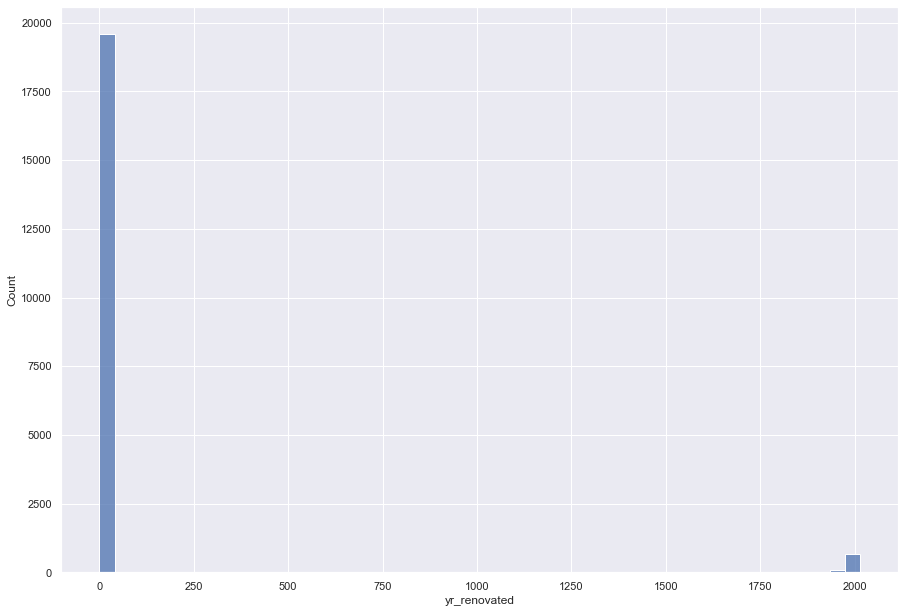

In [29]:
sns.histplot(data= df, x= 'yr_renovated', bins=50);

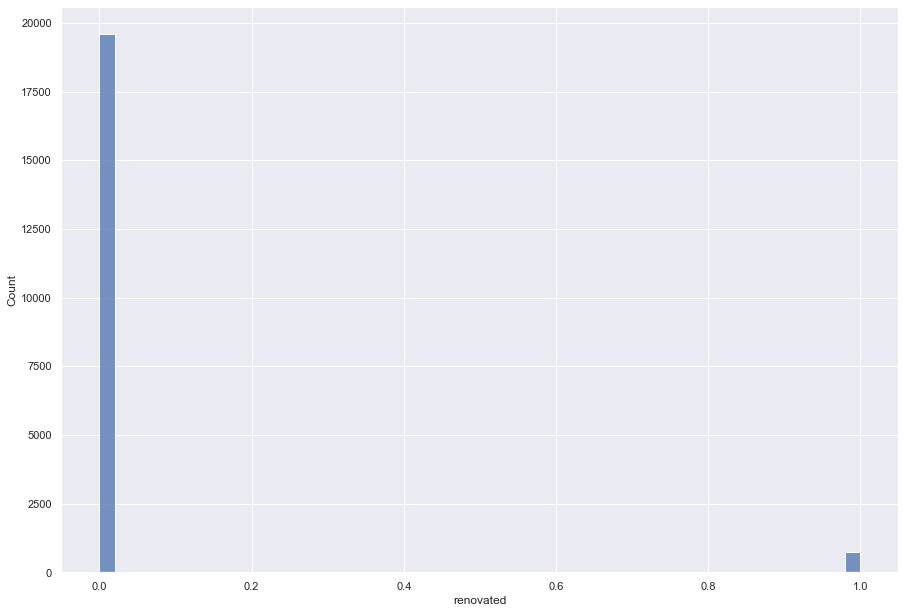

In [30]:
df.loc[df.yr_renovated > 0, 'yr_renovated'] = 1
df.rename(columns={'yr_renovated': 'renovated'}, inplace = True)

sns.histplot(data= df, x= 'renovated', bins=50);

### 6.1.11 Columns sqft

* sqft_basement possui muito valores com 0, irei transformar a coluna em binário
* 0 = não possui porão
* 1 = possui porão

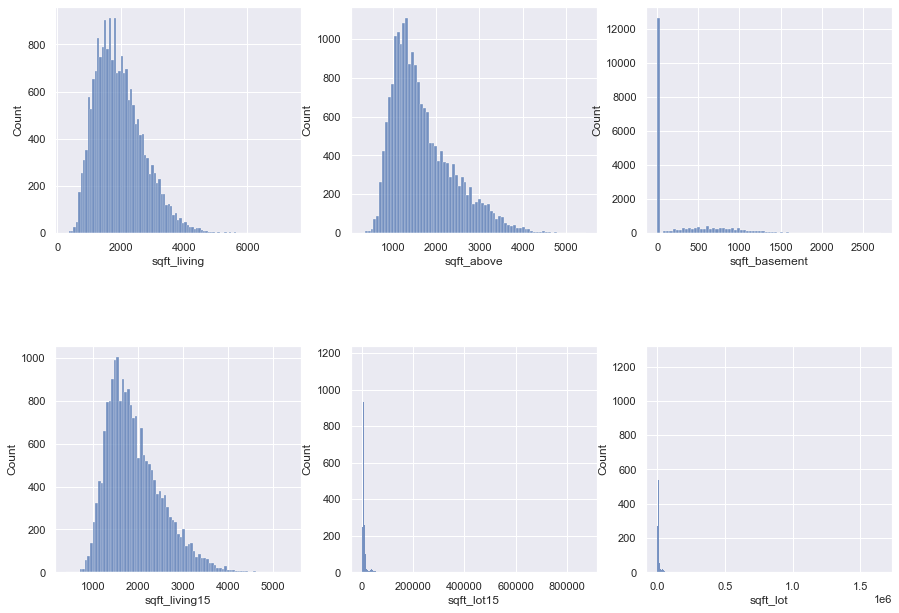

In [31]:
df_sqft = df[['sqft_living','sqft_above','sqft_basement','sqft_living15','sqft_lot15','sqft_lot']]
var = df_sqft.columns.to_list()


i = 1
for column in df_sqft[var].columns:
    plt.subplot(2,3,i)
    sns.histplot(data= df_sqft, x=column)
    i += 1

plt.subplots_adjust(hspace=0.5)
plt.show()

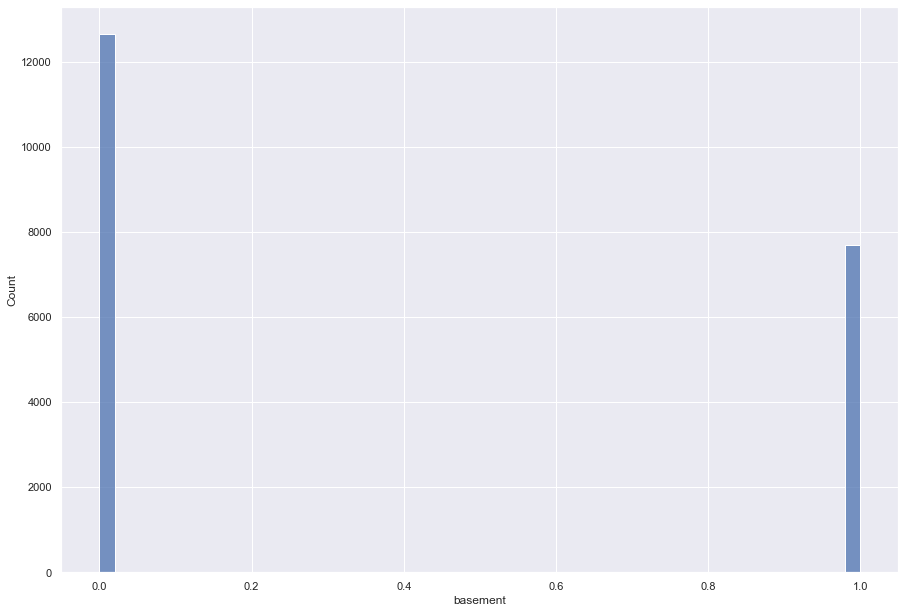

In [32]:
df.loc[df.sqft_basement > 0, 'sqft_basement'] = 1
df.rename(columns={'sqft_basement': 'basement'}, inplace = True)

sns.histplot(data= df, x= 'basement', bins=50);

### 6.1.12 Zipcode

* Coluna "CEP"

In [33]:
df['zipcode'].value_counts()

98038    588
98103    587
98052    557
98115    557
98042    547
        ... 
98102     88
98109     86
98024     72
98148     56
98039      6
Name: zipcode, Length: 70, dtype: int64

### 6.1.13 ID, Date, Lat, Long

* Essas colunas não fazem parte do escopo do problema, serão removidas.

In [34]:
df.drop(['id','lat','long','date'], axis=1, inplace=True)

In [36]:
df.shape

(20352, 17)

* Foram retirados 1261 linhas da base de dados, o que equivale à 6% de toda a base.

## 6.2 Bivariate Analysis

* Nessa etapa será feita a criação das hipóteses e a validação.

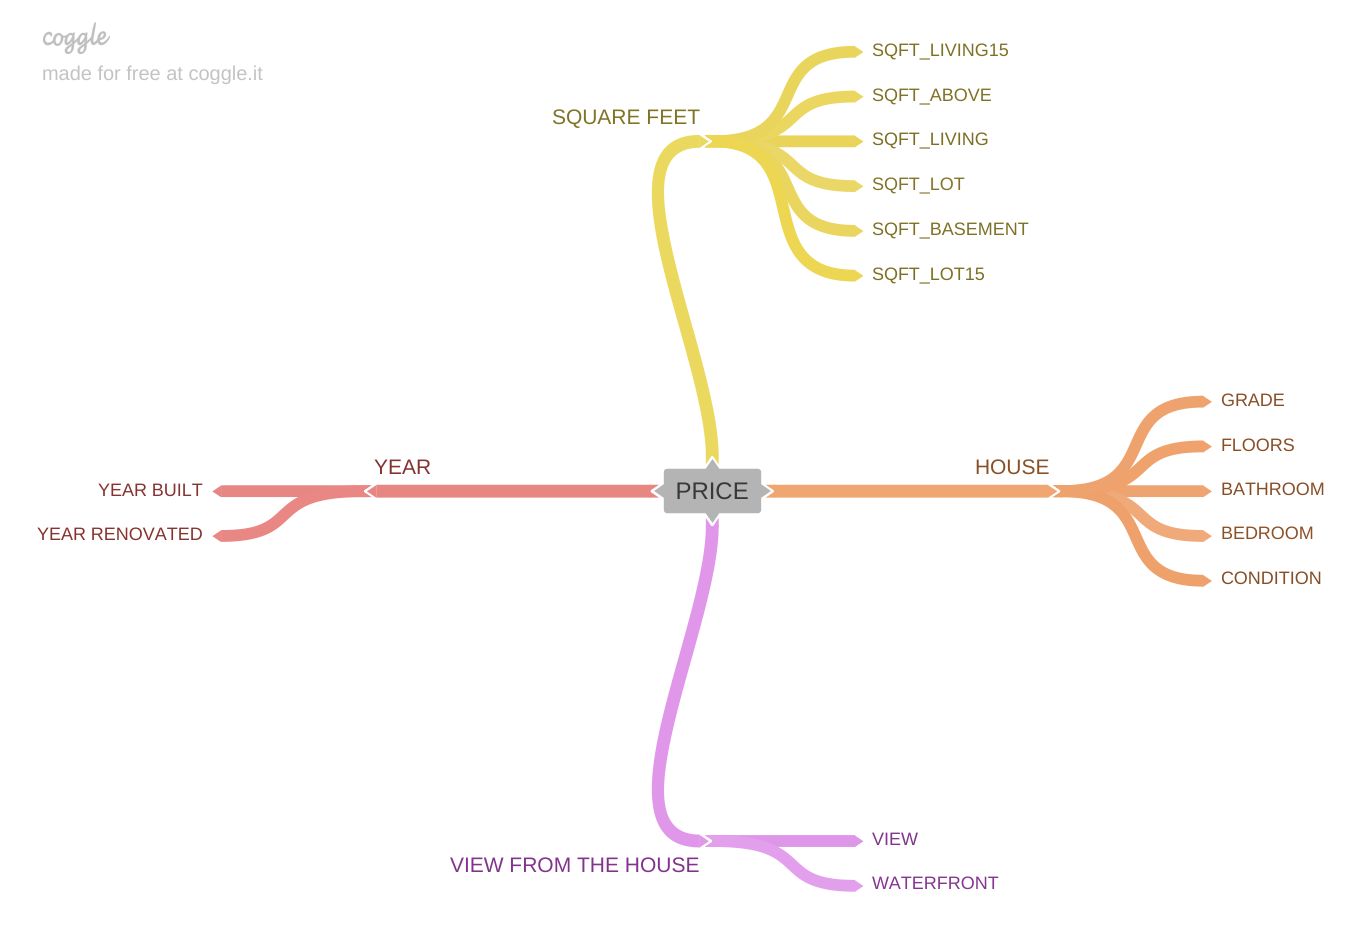

In [37]:
Image(filename='hipóteses.png') 

## 6.2.1 Hyphoteses

* Os imóveis que possuem porão são 50% mais caros, na média.
* Os imóveis que foram renovados são 25% mais caros, na média.
* Os imóveis que foram construídos antes de 1960 são 10% mais caros, na média.
* Os imóveis com mais de dois andares são 65% mais caros, na média.
* Os imóveis com mais de dois banheiros são 10% mais caros, na média.
* Os imóveis com mais de três quartos são 40% mais caros, na média.
* Os imóveis com a condição maior que 3 são 80% mais caros, na média.
* Os imóveis com a sala de estar maior que 2000ft são 25% mais caros, na média.

### Os imóveis que possuem porão são 50% mais caros, na média.
**FALSE:** Os imóveis que possuem porão são 15% mais caros, na média.

In [38]:
dff = df.reset_index()

In [39]:
df1 = dff[['price','basement']].groupby('basement').mean().reset_index()
df1

,basement,price
0,0,449086.66
1,1,518686.49


the PERCENT is: 15%


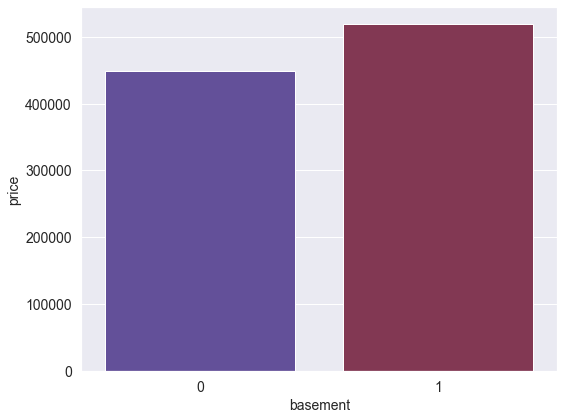

In [40]:
get_percent(df1)
make_barplot(df1, 'basement', 'price')

### Os imóveis que foram renovados são 25% mais caros, na média.
**FALSE:** Os imóveis que foram renovados são 19% mais caros, na média.

In [41]:
df2 = dff[['price','renovated']].groupby('renovated').mean().reset_index()
df2

,renovated,price
0,0,472075.21
1,1,562334.78


the PERCENT is: 19%


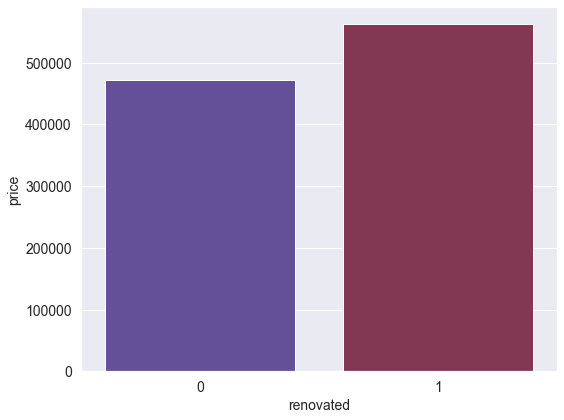

In [42]:
get_percent(df2)
make_barplot(df2, 'renovated', 'price')

### Os imóveis que foram construídos antes de 1960 são 10% mais caros, na média.
**FALSE:** Os imóveis que foram construídos antes de 1960 são 4% mais baratos do que os novos, na média.

In [43]:
df3 = dff[['price','yr_built']].copy()

df3['status'] = 'NA'

for i in range(len(df3)):
    if (df3.loc[i, 'yr_built'] <= 1960):
        df3.loc[i,'status'] = 'old'
    else:
        df3.loc[i,'status'] = 'new'
        
df3.drop(['yr_built'], axis=1, inplace=True)
df3 = df3.groupby('status')['price'].mean().reset_index()
df3

,status,price
0,new,481959.03
1,old,463587.77


the PERCENT is: 4%


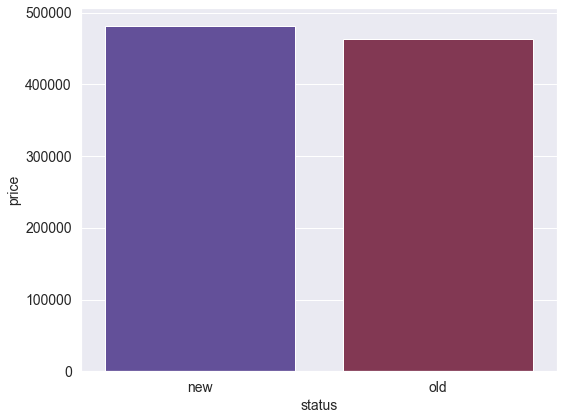

In [44]:
get_percent(df3)
make_barplot(df3, 'status', 'price')

### Os imóveis com mais de dois andares são 65% mais caros, na média.
**FALSE:** Os imóveis com mais de dois andares são 26% mais caros, na média.

In [45]:
df4 = dff[['price','floors']].copy()
df4['status'] = 'NA'

for i in range(len(df4)):
    if (df4.loc[i,'floors'] < 2):
        df4.loc[i,'status'] = 'Below 2 floors'
    else:
        df4.loc[i,'status'] = 'Above 2 floors'
        
df4.drop(['floors'], axis=1, inplace=True)
df4 = df4[['status','price']].groupby('status').mean().reset_index()
df4

,status,price
0,Above 2 floors,542788.35
1,Below 2 floors,430962.39


the PERCENT is: 26%


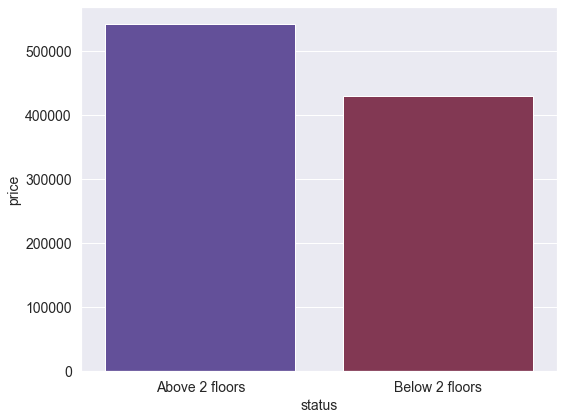

In [46]:
get_percent(df4)
make_barplot(df4, 'status', 'price')

### Os imóveis com mais de dois banheiros são 10% mais caros, na média.
**TRUE:** Os imóveis com mais de dois banheiros são 37% mais caros, na média.

In [47]:
df5 = dff[['price','bathrooms']].copy()
df5['status'] = 'NA'

for i in range(len(df5)):
    if (df5.loc[i,'bathrooms'] < 2):
        df5.loc[i,'status'] = 'Below 2 bathrooms'
    else:
        df5.loc[i,'status'] = 'Above 2 bathrooms'
        
df5.drop(['bathrooms'], axis=1, inplace=True)
df5 = df5[['status','price']].groupby('status').mean().reset_index()
df5

,status,price
0,Above 2 bathrooms,534635.58
1,Below 2 bathrooms,391042.95


the PERCENT is: 37%


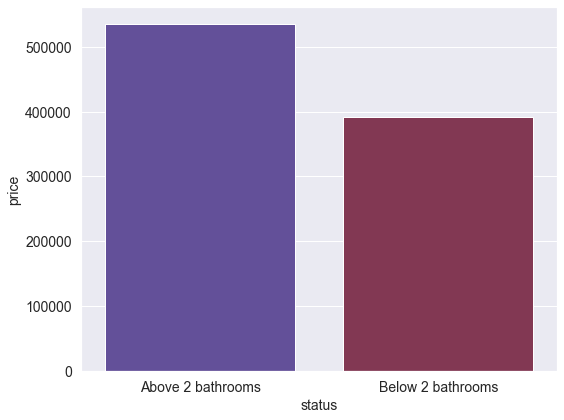

In [48]:
get_percent(df5)
make_barplot(df5, 'status', 'price')

### Os imóveis com mais de três quartos são 40% mais caros, na média.
**FALSE:** Os imóveis com mais de três quartos são 27% mais caros, na média.

In [49]:
df6 = dff[['price','bedrooms']].copy()
df6['status'] = 'NA'

for i in range(len(df6)):
    if (df6.loc[i,'bedrooms'] < 3):
        df6.loc[i,'status'] = 'Below 3 bedrooms'
    else:
        df6.loc[i,'status'] = 'Above 3 bedrooms'
        
df6.drop(['bedrooms'], axis=1, inplace=True)
df6 = df6[['status','price']].groupby('status').mean().reset_index()
df6

,status,price
0,Above 3 bedrooms,490488.09
1,Below 3 bedrooms,386386.55


the PERCENT is: 27%


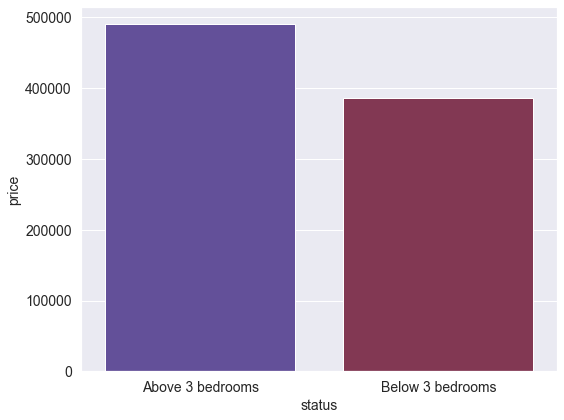

In [50]:
get_percent(df6)
make_barplot(df6, 'status', 'price')

### Os imóveis com a condição maior que 3 são 80% mais caros, na média.
**FALSE:** Os imóveis com a condição maior que 3 são 80% mais caros, na média.

In [51]:
df7 = dff[['price','condition']].copy()
df7['status'] = 'NA'

for i in range(len(df7)):
    if (df7.loc[i,'condition'] < 3):
        df7.loc[i,'status'] = 'Below 3 condition'
    else:
        df7.loc[i,'status'] = 'Above 3 condition'
        
df7.drop(['condition'], axis=1, inplace=True)
df7 = df7[['status','price']].groupby('status').mean().reset_index()
df7

,status,price
0,Above 3 condition,477083.27
1,Below 3 condition,306891.15


the PERCENT is: 55%


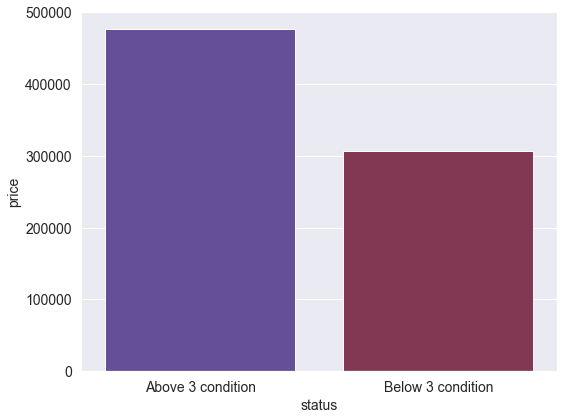

In [52]:
get_percent(df7)
make_barplot(df7, 'status', 'price')

### Os imóveis com a sala de estar maior que 2000ft são 25% mais caros, na média.
**TRUE:** Os imóveis com a sala de estar maior que 2000ft são 55% mais caros, na média

In [53]:
df8 = dff[['price','sqft_living']].copy()
df8['status'] = 'NA'

for i in range(len(df8)):
    if (df8.loc[i,'sqft_living'] < 2000):
        df8.loc[i,'status'] = 'Below 2000ft '
    else:
        df8.loc[i,'status'] = 'Above 2000ft'
        
df8.drop(['sqft_living'], axis=1, inplace=True)
df8 = df8[['status','price']].groupby('status').mean().reset_index()
df8

,status,price
0,Above 2000ft,596378.44
1,Below 2000ft,383974.33


the PERCENT is: 55%


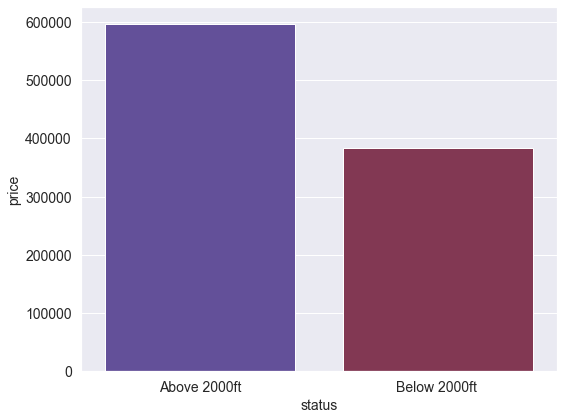

In [54]:
get_percent(df8)
make_barplot(df8, 'status', 'price')

## 6.3 Multivariate Analysis

* Através dessa matriz de correlação, podemos observar que há bastante correlação positiva entre as variáveis.

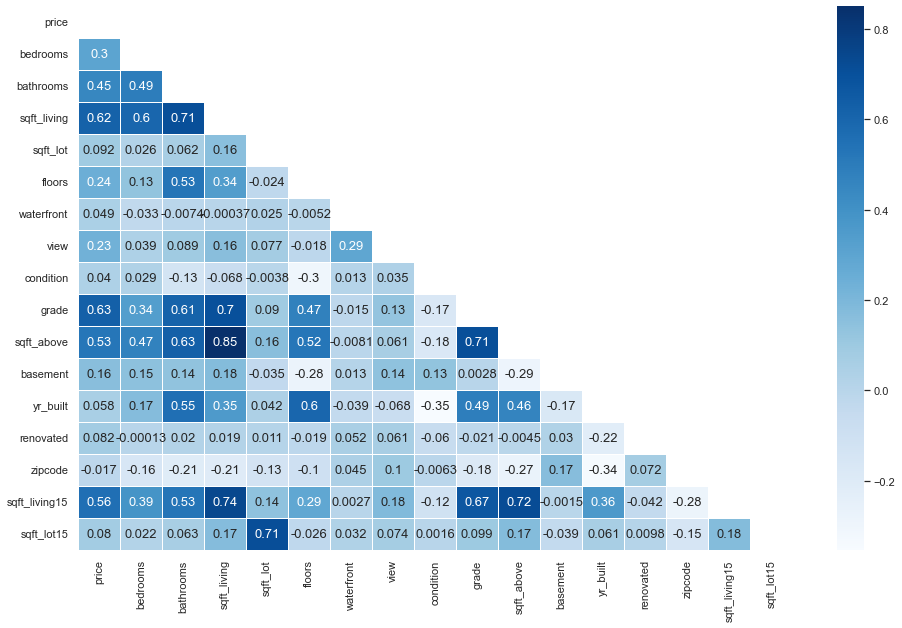

In [55]:
mask = np.zeros_like(df.corr())
triangle_indices = np.triu_indices_from(mask)
mask[triangle_indices] = True

sns.set_style('white')
plt.figure(figsize=(16,10))

sns.heatmap(df.corr(), cmap="Blues", annot=True, mask=mask, annot_kws={'size': 13}, linewidths=0.5)


plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.show()

# 7.0 Preprocessing

## 7.1 Feature Selection 

* Podemos observar algumas diferenças nos dois tipos de seleção de features.
* Irei utilizar o **Feature Importance** e remover algumas colunas menos relevantes.

### 7.1.1 SelectKBest

In [56]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

model = SelectKBest(score_func= f_regression, k=8)
fit = model.fit(X,y)

feat = fit.transform(X)

print(feat)

cols = fit.get_support(indices=True)
X.iloc[:, cols]

[[3.00e+00 1.00e+00 1.18e+03 ... 7.00e+00 1.18e+03 1.34e+03]
 [3.00e+00 2.25e+00 2.57e+03 ... 7.00e+00 2.17e+03 1.69e+03]
 [2.00e+00 1.00e+00 7.70e+02 ... 6.00e+00 7.70e+02 2.72e+03]
 ...
 [2.00e+00 1.00e+00 1.02e+03 ... 7.00e+00 1.02e+03 1.02e+03]
 [3.00e+00 2.50e+00 1.60e+03 ... 8.00e+00 1.60e+03 1.41e+03]
 [2.00e+00 1.00e+00 1.02e+03 ... 7.00e+00 1.02e+03 1.02e+03]]


,bedrooms,bathrooms,sqft_living,floors,view,grade,sqft_above,sqft_living15
0,3,1.00,1180,1,0,7,1180,1340
1,3,2.25,2570,2,0,7,2170,1690
2,2,1.00,770,1,0,6,770,2720
3,4,3.00,1960,1,0,7,1050,1360
4,3,2.00,1680,1,0,8,1680,1800
...,...,...,...,...,...,...,...,...
21608,3,2.50,1530,3,0,8,1530,1530
21609,4,2.50,2310,2,0,8,2310,1830
21610,2,1.00,1020,2,0,7,1020,1020
21611,3,2.50,1600,2,0,8,1600,1410


### 7.1.2 Feature Importances

[0.0076979  0.01422649 0.25455188 0.03381391 0.00388276 0.00126032
 0.00995868 0.009259   0.23916129 0.02921252 0.00299784 0.10762905
 0.0018831  0.17024729 0.0617144  0.05250356]


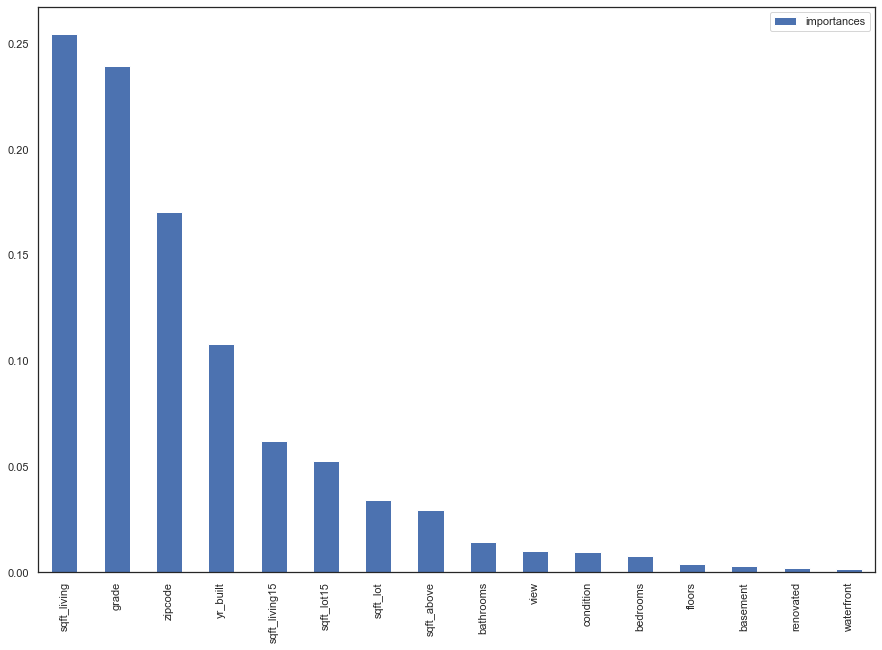

In [57]:
sel = RandomForestRegressor(n_estimators= 50)
sel.fit(X, y)

print(sel.feature_importances_)

feat_imp = pd.DataFrame(sel.feature_importances_, index = X.columns, 
                        columns=['importances']).sort_values('importances', ascending=False)

feat_imp.plot(kind='bar');

In [58]:
df.drop(['waterfront','floors','view','condition','basement','renovated'], axis=1, inplace=True)

In [59]:
df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,grade,sqft_above,yr_built,zipcode,sqft_living15,sqft_lot15
0,221900.00,3,1.00,1180,5650,7,1180,1955,98178,1340,5650
1,538000.00,3,2.25,2570,7242,7,2170,1951,98125,1690,7639
2,180000.00,2,1.00,770,10000,6,770,1933,98028,2720,8062
3,604000.00,4,3.00,1960,5000,7,1050,1965,98136,1360,5000
4,510000.00,3,2.00,1680,8080,8,1680,1987,98074,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...
21608,360000.00,3,2.50,1530,1131,8,1530,2009,98103,1530,1509
21609,400000.00,4,2.50,2310,5813,8,2310,2014,98146,1830,7200
21610,402101.00,2,1.00,1020,1350,7,1020,2009,98144,1020,2007
21611,400000.00,3,2.50,1600,2388,8,1600,2004,98027,1410,1287


## 7.2 Scaling and Splitting Data

In [60]:
X = df.drop('price', axis=1)
y = df['price'].astype(np.int64)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((14246, 10), (14246,), (6106, 10), (6106,))

# 8.0 Machine Learning Modeling

## 8.1 Random Forest

In [61]:
model = RandomForestRegressor(random_state=0)
model.fit(X_train, y_train)

metrics(X_train, y_train, X_test, y_test, model)

MSE: 9212822582.374235

RMSE: 95983.4495232081

R2: 0.7846790152730466

MAE: 67684.8662438156


## 8.2 Lasso

In [62]:
model = Lasso()
model.fit(X_train, y_train)

metrics(X_train, y_train, X_test, y_test, model)

MSE: 18426880341.00479

RMSE: 135745.64575338978

R2: 0.569329162154735

MAE: 106054.8662297968


## 8.3 ElasticNet

In [63]:
model = ElasticNet(random_state=0)
model.fit(X_train, y_train)

metrics(X_train, y_train, X_test, y_test, model)

MSE: 20822099699.176334

RMSE: 144298.64759995617

R2: 0.5133483825155762

MAE: 114627.71434376185


# 9.0 Hyperparemeter fine-tuning

* Nessa etapa faremos o uso do **RandomSearchCV** para encontrarmos os melhores parâmetros de cada algoritmo.
* **Random Forest** teve o pior desempenho com esses parâmetros, irei utilizar apenas o parâmetro "min_samples_split"
* **ElasticNet** teve um bom desempenho com os parâmetros definidos.
* **Lasso** Não mudou muita coisa em relação com os parâmetros default.

In [66]:
model = RandomForestRegressor()

parameters = {'criterion':         ['squared_error','absolute_error'],
              'n_estimators':      [10, 40, 100, 150],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf':  [1, 5, 10],
              'max_depth':         [1, 2, 5]}

random_search(model, parameters, X_train, y_train)

The results obtained were:

Best MAE found: 105694

Best parameters found: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 5, 'criterion': 'squared_error'}

Estimators found: RandomForestRegressor(max_depth=5, min_samples_split=10)


In [65]:
model = ElasticNet()

parameters = {'max_iter':          [1, 5, 10, 100, 1000],
              'alpha':             [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
              'l1_ratio':          [0.0, 1.0, 0.1]}

random_search(model, parameters, X_train, y_train)

The results obtained were:

Best MAE found: 118022

Best parameters found: {'max_iter': 100, 'l1_ratio': 1.0, 'alpha': 0.001}

Estimators found: ElasticNet(alpha=0.001, l1_ratio=1.0, max_iter=100)


In [64]:
model = Lasso()

parameters = {'max_iter': [1, 5, 10, 15,150],
              'alpha':    [0.02, 0.024, 0.025, 0.026, 0.03, 100],
              'tol':      [0.001, 0.0001, 0.1, 0]}

random_search(model, parameters, X_train, y_train)

The results obtained were:

Best MAE found: 118020

Best parameters found: {'tol': 0.0001, 'max_iter': 15, 'alpha': 100}

Estimators found: Lasso(alpha=100, max_iter=15)


# 10.0 Cross-Validation

* Irei submeter os algoritmos para uma avaliação.
* O melhor algoritmo de fato foi o Random Forest.

In [75]:
results_random = []
results_elastic = []
results_lasso = []

for i in range(10):
  kf = KFold(n_splits=10, shuffle=True, random_state=i)
  
  random = RandomForestRegressor(min_samples_split=10)
  mae = cross_val_score(random, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')
  results_random.append(mae.mean())

  elastic = ElasticNet(alpha=0.0001, l1_ratio=0.9, max_iter=100)
  mae = cross_val_score(elastic, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')
  results_elastic.append(mae.mean())

  lasso = Lasso(alpha=100, max_iter=150, tol=0.1)
  mae = cross_val_score(lasso, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')
  results_lasso.append(mae.mean())

results = pd.DataFrame({'Random Forest': results_random,
                       'ElasticNet': results_elastic,
                       'Lasso': results_lasso})

abs(results).sort_values('Random Forest')

,Random Forest,ElasticNet,Lasso
3,66452.644509,117945.460012,117941.798901
1,66586.137100,117939.753951,117934.209865
7,66674.704888,117935.560971,117930.855338
5,66735.050910,117926.119720,117921.573269
6,66789.302606,117936.743136,117929.039668
2,66793.396402,117966.458725,117963.541411
0,66817.735958,117971.117574,117965.413024
9,66854.008310,117937.166191,117930.331969
8,66901.179735,117949.092131,117945.413889
4,66906.599806,117957.728631,117952.371244


# 11.0 Translation of model performance to business performance

In [77]:
df = df.reset_index()

df['price_new'] = 'NA'

for i in range(len(df)):
    if (df.loc[i, 'renovated'] == 0):
        df.loc[i, 'price_new'] = df.loc[i,'price'] * 1.3
    else:
        df.loc[i, 'price_new'] = df.loc[i,'price'] * 1.1
        
report = pd.DataFrame()
report = df[['renovated','price_new']].copy()

r1 = report[['price_new','renovated']].groupby('renovated').sum().reset_index()
r1

,renovated,price_new
0,0,12027248966.20
1,1,466400465.30


# 12.0 Deploy

* Salvando a máquina preditiva em pkl, para poder utilizar na aplicação.

In [409]:
X = df.drop('price', axis=1)
y = df['price'].astype(np.int64)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

random = RandomForestRegressor(min_samples_split=10)
random.fit(X_train, y_train)

RandomForestRegressor(min_samples_split=10)

In [410]:
pickle.dump(random, open('model_random.pkl','wb'))

In [411]:
model = pickle.load(open('model_random.pkl','rb'))

In [417]:
# bedrooms - bathrooms - sqft_living - sqft_lot - grade - sqft_above - yr_built - zipcode - sqft_living15 - sqft_lot15
pred = np.array([[3, 2, 3000, 2000, 3, 1500, 1990, 98001,1000, 1000]])
pred2 = np.array([[1, 1, 1000, 3000, 1, 1000, 2015, 98008,2000, 5000]])
pred3 = np.array([[2, 2, 3500, 1000, 11, 20000, 1960, 98011,3000, 7000]])

In [418]:
model.predict(pred)

array([402290.82118101])

In [419]:
model.predict(pred2)

array([317565.15966527])

In [420]:
model.predict(pred3)

array([865297.08685847])